<a href="https://colab.research.google.com/github/Rogerio-mack/data-engineering/blob/main/how_run_wordcount_example_on_docker_hadoop_not_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HDFS "Taste"**:  wordcount example from docker-hadoop

Vamos experimentar o Hadoop e executar o wordcount examplo do hadoop em um  docker-hadoop container. Isso permitirá você ter uma ideia melhor de como o Hadoop funciona. Note, este notebook **DOES NOT RUN in Colab!**. Os procedimentos abaixo foram executados em um Docker container em um Ubuntu do WSL2.

# Get docker-hadoop

Há muitas outras imagens de containers de hadoop disponíveis.

In [ ]:
docksudo git clone https://github.com/big-data-europe/docker-hadoop

Cloning into 'docker-hadoop'...
remote: Enumerating objects: 539, done.
remote: Total 539 (delta 0), reused 0 (delta 0), pack-reused 539
Receiving objects: 100% (539/539), 108.43 KiB | 6.02 MiB/s, done.
Resolving deltas: 100% (249/249), done.


In [ ]:
ls /docker-hadoop  -l

total 52
drwxr-xr-x 2 root root 4096 Jul 18 15:27 base
drwxr-xr-x 2 root root 4096 Jul 18 15:27 datanode
-rw-r--r-- 1 root root 2522 Jul 18 15:27 docker-compose-v3.yml
-rw-r--r-- 1 root root 1559 Jul 18 15:27 docker-compose.yml
-rw-r--r-- 1 root root 2507 Jul 18 15:27 hadoop.env
drwxr-xr-x 2 root root 4096 Jul 18 15:27 historyserver
-rw-r--r-- 1 root root 1437 Jul 18 15:27 Makefile
drwxr-xr-x 2 root root 4096 Jul 18 15:27 namenode
drwxr-xr-x 2 root root 4096 Jul 18 15:27 nginx
drwxr-xr-x 2 root root 4096 Jul 18 15:27 nodemanager
-rw-r--r-- 1 root root 2171 Jul 18 15:27 README.md
drwxr-xr-x 2 root root 4096 Jul 18 15:27 resourcemanager
drwxr-xr-x 2 root root 4096 Jul 18 15:27 submit


### **!** Execute este somente para desinstalar e refazer o git clone

In [ ]:
cd /docker-hadoop
sudo rm -rf .git
cd /
sudo rm -rf /docker-hadoop

# docker-compose.yml

**YAML** (YAML Ain't Markup Language) é um formato de serialização de dados leve e humanamente legível bastante utilizado para configurar aplicativos e serviços. O **Docker Compose**  facilita a definição e o gerenciamento de aplicações Docker permitindo em um único comando, criar e iniciar todos os serviços de sua aplicação a partir de um arquivo de configuração YAML.

O `docker-compose.yml` cria os containers do componentes do seu ambiente Hadoop (para ser mais preciso, do seu sistema HDFS).

<br>

* **ResourceManager**: É responsável por gerenciar os recursos do cluster, como a alocação de memória, CPU e armazenamento.
* **NameNode**: É responsável por gerenciar o sistema de arquivos distribuído do HDFS. Ele mantém o registro de todos os arquivos armazenados e suas localizações.
* **NodeManager**: É o componente responsável por gerenciar os nós de trabalho do cluster. Ele inicia e monitora as tarefas de processamento.
* **DataNode**: É responsável por armazenar os dados do HDFS. Ele é responsável por replicar os dados entre os diferentes nós do cluster para a alta disponibilidade.
* **HistoryServer**: É responsável por armazenar o histórico das tarefas de processamento executadas no cluster e permite visualizar o progresso e o status das tarefas.


>> **YARN**? O **YARN** (Yet Another Resource Negotiator) é um framework fundamental no Hadoop, responsável por gerenciar os recursos do cluster e por agendar as tarefas. É como um sistema operacional para o seu cluster Hadoop, responsável por alocar os recursos computacionais necessários para executar as suas aplicações.

In [ ]:
services:
  namenode:
    image: bde2020/hadoop-namenode:2.0.0-hadoop3.2.1-java8
    container_name: namenode
    restart: always
    ports:
      - 9870:9870
      - 9000:9000
    volumes:
      - hadoop_namenode:/hadoop/dfs/name
    environment:
      - CLUSTER_NAME=test
    env_file:
      - ./hadoop.env

  datanode:
    image: bde2020/hadoop-datanode:2.0.0-hadoop3.2.1-java8
    container_name: datanode
    restart: always
    volumes:
      - hadoop_datanode:/hadoop/dfs/data
    environment:
      SERVICE_PRECONDITION: "namenode:9870"
    env_file:
      - ./hadoop.env

(...)

Ao definir volumes no docker-compose, como:

```
    volumes:
      - hadoop_namenode:/hadoop/dfs/name
```
Você estará gerando **volumes persistentes**. Assim, embora os containers sejam conhecidos por sua volatilidade, os dados armazenados nesses volumes irão persistir.

O comando a seguir inicializa os serviços do HDFS,

In [ ]:
cd docker-hadoop
sudo docker-compose up -d

In [ ]:
sudo docker container ls

```
rogerio@DESKTOP-KRMG5G5:/docker-hadoop$ sudo docker container ls
CONTAINER ID   IMAGE                                                    COMMAND                  CREATED        STATUS                  PORTS                                                                                  NAMES
afd6e1e96a72   bde2020/hadoop-resourcemanager:2.0.0-hadoop3.2.1-java8   "/entrypoint.sh /run…"   21 hours ago   Up 21 hours (healthy)   8088/tcp                                                                               resourcemanager
f075a1d7eb19   bde2020/hadoop-namenode:2.0.0-hadoop3.2.1-java8          "/entrypoint.sh /run…"   21 hours ago   Up 21 hours (healthy)   0.0.0.0:9000->9000/tcp, :::9000->9000/tcp, 0.0.0.0:9870->9870/tcp, :::9870->9870/tcp   namenode
606b00fcc2ab   bde2020/hadoop-nodemanager:2.0.0-hadoop3.2.1-java8       "/entrypoint.sh /run…"   21 hours ago   Up 21 hours (healthy)   8042/tcp                                                                               nodemanager
12e2d5a3c772   bde2020/hadoop-datanode:2.0.0-hadoop3.2.1-java8          "/entrypoint.sh /run…"   21 hours ago   Up 21 hours (healthy)   9864/tcp                                                                               datanode
a44b1fddbcb9   bde2020/hadoop-historyserver:2.0.0-hadoop3.2.1-java8     "/entrypoint.sh /run…"   21 hours ago   Up 21 hours (healthy)   8188/tcp                                                                               historyserver
```

# Executando um wordcount com Mapreduce

Essa é uma aplicação bastante comum para exemplificar o uso do mapreduce e há no hadoop uma aplicação exemplo, `.jar`, que pode ser executada diretamente.

## Obtendo o arquivos do texto e da aplicação wordcount

Os arquivos são "copiados" para o container `namenode` onde será feito o processamento.

In [ ]:
sudo wget https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-mapreduce-examples/3.4.0/hadoop-mapreduce-examples-3.4.0.jar
sudo docker cp hadoop-mapreduce-examples-3.4.0.jar namenode:/tmp/

sudo wget -q https://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/1/0/101/101.txt
sudo docker cp 101.txt namenode:/tmp

--2024-07-18 15:40:03--  https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-mapreduce-examples/3.4.0/hadoop-mapreduce-examples-3.4.0.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 281609 (275K) [application/java-archive]
Saving to: ‘hadoop-mapreduce-examples-3.4.0.jar’

hadoop-mapreduce-ex 100%[===================>] 275.01K  --.-KB/s    in 0.02s   

2024-07-18 15:40:03 (10.8 MB/s) - ‘hadoop-mapreduce-examples-3.4.0.jar’ saved [281609/281609]



## Entre no container do `namenode`

Verifique a versão do Hadoop.

In [ ]:
sudo docker exec -it namenode /bin/bash

In [ ]:
hadoop version

```
Hadoop 3.2.1
Source code repository https://gitbox.apache.org/repos/asf/hadoop.git -r b3cbbb467e22ea829b3808f4b7b01d07e0bf3842
Compiled by rohithsharmaks on 2019-09-10T15:56Z
Compiled with protoc 2.5.0
From source with checksum 776eaf9eee9c0ffc370bcbc1888737
This command was run using /opt/hadoop-3.2.1/share/hadoop/common/hadoop-common-3.2.1.jar
```

## Copiando o arquivo para o HDFS


1. Você envia o arquivo para o **NameNode**: O NameNode registra a localização do arquivo e divide-o em blocos. Ele envia os blocos para os DataNodes selecionados e atualiza o registro no NameNode. Isso será feito aqui:

```(bash)
         hdfs dfs -put /tmp/101.txt /rogerio/101.txt
```

2. O **NameNode** informa aos **DataNodes** onde armazenar os blocos: Os DataNodes recebem os blocos e os armazenam em seus discos locais.

Os **NameNode** não armazenam os dados reais dos arquivos.

In [ ]:
ls -l /tmp

```
root@f075a1d7eb19:/# ls -l /tmp
total 952
-rw-r--r-- 1 root root 678064 Feb  9  2012 101.txt
-rw-r--r-- 1 root root 281609 Mar  4 07:29 hadoop-mapreduce-examples-3.4.0.jar
-rw-r--r-- 1 root root      4 Jul 17 18:21 hadoop-root-namenode.pid
drwxr-xr-x 1 root root   4096 Jul 18 15:48 hsperfdata_root
drwxr-xr-x 2 root root   4096 Jul 17 18:21 jetty-0.0.0.0-9870-hdfs-_-any-6076419249978838926.dir
root@f075a1d7eb19:/#
```



In [ ]:
hdfs dfs -ls /
hdfs dfs -mkdir -p /rogerio/root
hdfs dfs -put /tmp/101.txt /rogerio/101.txt
hdfs dfs -ls /rogerio

```
root@f075a1d7eb19:/# hdfs dfs -ls /rogerio
Found 2 items
-rw-r--r--   3 root supergroup     678064 2024-07-18 16:08 /rogerio/101.txt
drwxr-xr-x   - root supergroup          0 2024-07-18 16:06 /rogerio/root
```

In [ ]:
hdfs dfs -cat /rogerio/101.txt

```
root@f075a1d7eb19:/# hdfs dfs -head /rogerio/101.txt
2024-07-18 16:31:16,298 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
The Project Gutenberg EBook of Hacker Crackdown, by Bruce Sterling

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org

** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **
**     Please follow the copyright guidelines in this file.     **

Title: Hacker Crackdown
       Law and Disorder on the Electronic Frontier

Author: Bruce Sterling

Posting Date: February 9, 2012 [EBook #101]
Release Date: January, 1994
```

## Processando a aplicação exemplo wordcount

Como executará o wordcount?

1. O **ResourceManager** recebe a tarefa de WordCount: O JobTracker coordena a execução da tarefa em todo o cluster.
2. O JobTracker atribui tarefas aos TaskTrackers (**NodeManagers**): Cada TaskTracker executa uma parte da tarefa de WordCount nos dados armazenados localmente nos DataNodes.

>> **Distribuição de Processamento**. O modelo do Hadoop é baseado na distribuição de dados e processamento. Ao invés de centralizar o processamento em um único nó (como o NameNode), o Hadoop distribui as tarefas de processamento para os nós onde os dados estão armazenados, ou seja, os DataNodes.

Aqui, entretanto, temos apenas um datanode.


In [ ]:
hadoop jar /tmp/hadoop-mapreduce-examples-3.4.0.jar wordcount /rogerio/101.txt /rogerio/output

```
root@f075a1d7eb19:/# hadoop jar /tmp/hadoop-mapreduce-examples-3.4.0.jar wordcount /rogerio/101.txt /rogerio/output
2024-07-18 16:14:33,716 INFO client.RMProxy: Connecting to ResourceManager at resourcemanager/172.18.0.3:8032
2024-07-18 16:14:34,123 INFO client.AHSProxy: Connecting to Application History server at historyserver/172.18.0.6:10200
2024-07-18 16:14:34,911 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1721240533517_0002
2024-07-18 16:14:35,079 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-07-18 16:14:35,777 INFO input.FileInputFormat: Total input files to process : 1
2024-07-18 16:14:35,849 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-07-18 16:14:35,902 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-07-18 16:14:36,323 INFO mapreduce.JobSubmitter: number of splits:1
2024-07-18 16:14:36,591 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-07-18 16:14:37,037 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1721240533517_0002
2024-07-18 16:14:37,037 INFO mapreduce.JobSubmitter: Executing with tokens: []
2024-07-18 16:14:37,243 INFO conf.Configuration: resource-types.xml not found
2024-07-18 16:14:37,243 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
2024-07-18 16:14:38,697 INFO impl.YarnClientImpl: Submitted application application_1721240533517_0002
2024-07-18 16:14:38,775 INFO mapreduce.Job: The url to track the job: http://resourcemanager:8088/proxy/application_1721240533517_0002/
2024-07-18 16:14:38,775 INFO mapreduce.Job: Running job: job_1721240533517_0002
2024-07-18 16:14:55,013 INFO mapreduce.Job: Job job_1721240533517_0002 running in uber mode : false
2024-07-18 16:14:55,015 INFO mapreduce.Job:  map 0% reduce 0%
2024-07-18 16:15:07,263 INFO mapreduce.Job:  map 100% reduce 0%
2024-07-18 16:15:13,304 INFO mapreduce.Job:  map 100% reduce 100%
2024-07-18 16:15:14,319 INFO mapreduce.Job: Job job_1721240533517_0002 completed successfully
2024-07-18 16:15:14,460 INFO mapreduce.Job: Counters: 54
        File System Counters
                FILE: Number of bytes read=105562
                FILE: Number of bytes written=669665
                FILE: Number of read operations=0
                FILE: Number of large read operations=0
                FILE: Number of write operations=0
                HDFS: Number of bytes read=678165
                HDFS: Number of bytes written=233636
                HDFS: Number of read operations=8
                HDFS: Number of large read operations=0
                HDFS: Number of write operations=2
                HDFS: Number of bytes read erasure-coded=0
        Job Counters
                Launched map tasks=1
                Launched reduce tasks=1
                Rack-local map tasks=1
                Total time spent by all maps in occupied slots (ms)=33836
                Total time spent by all reduces in occupied slots (ms)=27352
                Total time spent by all map tasks (ms)=8459
                Total time spent by all reduce tasks (ms)=3419
                Total vcore-milliseconds taken by all map tasks=8459
                Total vcore-milliseconds taken by all reduce tasks=3419
                Total megabyte-milliseconds taken by all map tasks=34648064
                Total megabyte-milliseconds taken by all reduce tasks=28008448
        Map-Reduce Framework
                Map input records=13006
                Map output records=105488
                Map output bytes=1078906
                Map output materialized bytes=105554
                Input split bytes=101
                Combine input records=105488
                Combine output records=21438
                Reduce input groups=21438
                Reduce shuffle bytes=105554
                Reduce input records=21438
                Reduce output records=21438
                Spilled Records=42876
                Shuffled Maps =1
                Failed Shuffles=0
                Merged Map outputs=1
                GC time elapsed (ms)=3245
                CPU time spent (ms)=26040
                Physical memory (bytes) snapshot=651034624
                Virtual memory (bytes) snapshot=13560627200
                Total committed heap usage (bytes)=527958016
                Peak Map Physical memory (bytes)=454701056
                Peak Map Virtual memory (bytes)=5106589696
                Peak Reduce Physical memory (bytes)=196333568
                Peak Reduce Virtual memory (bytes)=8454037504
        Shuffle Errors
                BAD_ID=0
                CONNECTION=0
                IO_ERROR=0
                WRONG_LENGTH=0
                WRONG_MAP=0
                WRONG_REDUCE=0
        File Input Format Counters
                Bytes Read=678064
        File Output Format Counters
                Bytes Written=233636
   

## Exibindo a saída

Ela está no arquivo `part-r-00000` gerada no diretório de saída especificado.

In [ ]:
hdfs dfs -ls /rogerio/output

```
root@f075a1d7eb19:/# hdfs dfs -ls /rogerio/output
Found 2 items
-rw-r--r--   3 root supergroup          0 2024-07-18 16:15 /rogerio/output/_SUCCESS
-rw-r--r--   3 root supergroup     233636 2024-07-18 16:15 /rogerio/output/part-r-00000
```

In [ ]:
hdfs dfs -head /rogerio/output/part-r-00000

```
root@f075a1d7eb19:/# hdfs dfs -head /rogerio/output/part-r-00000
2024-07-18 16:21:00,892 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
"(d)    1
"/H"    1
"0"     1
"02"    2
"1.     1
"414    3
"A      2
"AT&T   3
"AT&T's 1
"Access 1
"Acid   3
"Ad-hocracy"    1
"Advanced       1
"Agents 1
"Al     3
"All    3
"American       1
"An     1
"And    2
"Any    1
"Are    3
"Artificial     1
```

# Acessando a interface do usuário

No browser: http://localhost:9870/

In [ ]:
!curl localhost:9870

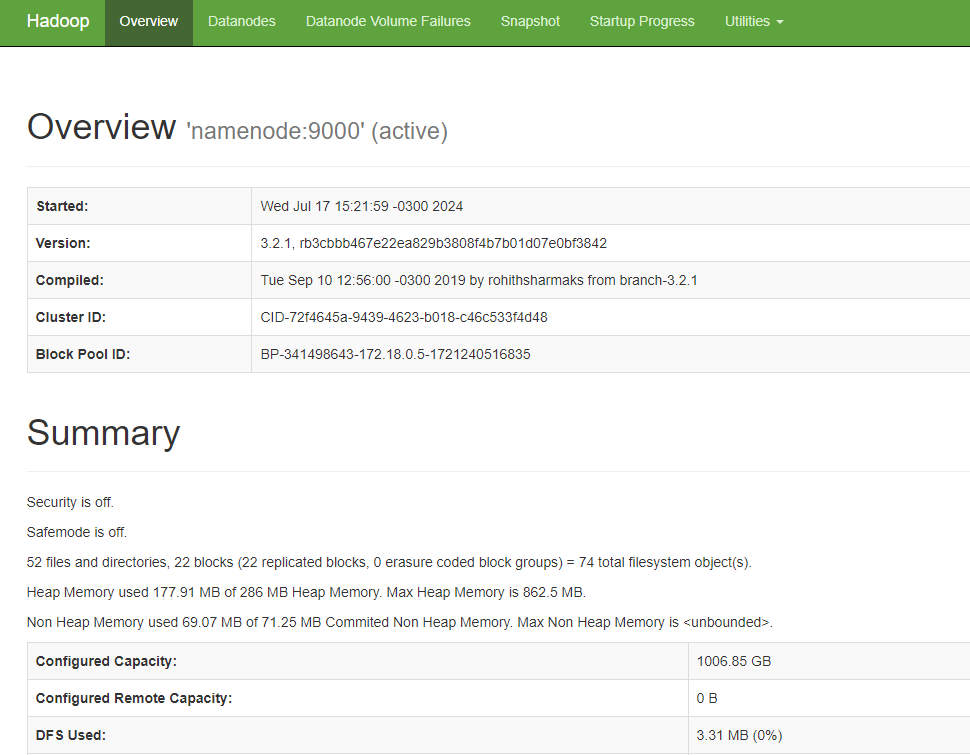